In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import requests

# NLP
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer

from nltk.corpus import stopwords
from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    PER,
    NamesExtractor,
    Doc
)

# ML
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from sklearn.decomposition import LatentDirichletAllocation

import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from tqdm import tqdm
tqdm.pandas()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Setup

In [2]:
start_date = '2011-03-01'
end_date = '2023-12-31'

data = pd.read_csv('data/lenta_2005-2025.csv')

# Stop-Words
resp = requests.get('https://raw.githubusercontent.com/stopwords-iso/stopwords-ru/master/stopwords-ru.json')
stop_words = list(stopwords.words('russian')) + eval(resp.text) + pd.read_csv('data/ru_stop_words.txt')['word'].to_list() # additional stop_words
stop_words = set(stop_words)

print('Total stop_words:', len(stop_words))

Total stop_words: 559


In [3]:
data['date'] = pd.to_datetime(data['pubdate'], unit='s')
texts = data[['date', 'title', 'text', 'url']]
texts.head()

,date,title,text,url
0,2010-01-01 14:45:29,Приказ о минимальной цене на водку вступил в силу,"Кадр ТВ-6, архив C 1 января 2010 года в России...",https://lenta.ru/news/2010/01/01/vodka/
1,2010-01-02 09:14:58,Fox и Time Warner Cable согласовали плату за т...,Штаб-квартира Time Warner в Нью-Йорке. Фото (c...,https://lenta.ru/news/2010/01/02/deal/
2,2010-01-03 03:09:44,Исландцы выразили протест против выплат компен...,Штаб-квартира Landsbanki. Фото (c)AFP Четверть...,https://lenta.ru/news/2010/01/03/iceland/
3,2010-01-03 15:36:03,Борцовский клуб,Фото (c)AFP Ирина Рябова Для российской эконом...,https://lenta.ru/articles/2010/01/03/finalecorus/
4,2010-01-03 19:29:06,Трейдеры сообщили о прекращении поставок росси...,Мозырский НПЗ. Фото (c)AFP Россия прекратила п...,https://lenta.ru/news/2010/01/03/oil/


## Corpus exploration

In [4]:
# Check for duplicates
texts.duplicated().sum()

1

In [5]:
# Check for missing values
texts.isnull().sum()

date       0
title      0
text     164
url        0
dtype: int64

In [6]:
texts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151215 entries, 0 to 151214
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    151215 non-null  datetime64[ns]
 1   title   151215 non-null  object        
 2   text    151051 non-null  object        
 3   url     151215 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 4.6+ MB


# Preprocessing

In [7]:
#Cleaning the text
def clean_text(text):
    #Converting all characters in the text to lowercase.
    text = text.lower()

    #Removing Punctuation.
    text = re.sub(r'[^\w\s]', '', text)
    
    #Removing Digits.
    text = re.sub(r'\d+', '', text)

    #Excluding Stopwords.
    return ' '.join(word for word in text.split() if word not in stop_words)


def lemmatize_text(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    for token in doc.tokens:
        token.lemmatize(morph_vocab)
        
    lemmas = [token.lemma for token in doc.tokens]
    return ' '.join(lemmas)


In [8]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)
names_extractor = NamesExtractor(morph_vocab)

texts = texts.dropna()
texts = texts.drop_duplicates()
texts['date'] = pd.to_datetime(texts['date']).dt.date.astype(str)

texts = texts[(texts['date'] >= start_date) & (texts['date'] <= end_date)]
texts['clean_text'] = texts['text'].apply(clean_text)

# Apply the lemmatization function to each text in the DataFrame
texts['lemmatized_text'] = texts['clean_text'].progress_apply(lemmatize_text)

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 66365/96199 [19:20<07:03, 70.43it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
%%time
print('Before lemmatization:\n', texts['clean_text'].values[0])
print('\nAfter lemmatization:\n', texts['lemmatized_text'].values[0])

Before lemmatization:
 здание газпрома фото cafp газпром ходе торгов приобрел имущество обанкротившейся компании русиа петролеум оператора гигантского ковыктинского газоконденсатного месторождения иркутской области сообщает риа новости ссылкой представителя русиа петролеум сумма которую газпром заплатит актив включающий лицензию освоение ковыкты незначительно превышает стартовую цену миллиардов рублей источники интерфакса заявили газпром заплатил миллиарда рублей имущество русиа петролеум полтора раза превысив стартовую цену газпром выиграл торги лицензия переоформлена победитель торгов преимущественное право получение лицензии цитирует reuters представителя конкурсного управляющего русиа петролеум ранее сообщалось конкурсе покупку имущества компании русиа петролеум претендуют участника государственные газпром роснефтегаз банкротство русиа петролеум инициировано основным акционером компании российскобританской тнкbp вынуждена свернуть освоение ковыкты неудачных попыток продать актив со

In [10]:
texts.head()

,date,title,text,url,clean_text,lemmatized_text
6925,2011-03-01,"""Газпром"" выкупил право на разработку Ковыкты","Здание ""Газпрома"". Фото (c)AFP ""Газпром"" в ход...",https://lenta.ru/news/2011/03/01/kovykta/,здание газпрома фото cafp газпром ходе торгов ...,здание газпром фото cafp газпром ход торг прио...
6926,2011-03-01,Курорты Северного Кавказа уравняют в налоговых...,Эльбрус. Фото с сайта elbrus-cheget.ru Туристи...,https://lenta.ru/news/2011/03/01/ksk/,эльбрус фото сайта elbruschegetru туристически...,эльбрус фото сайт elbruschegetru туристический...
6927,2011-03-01,"""Ростелеком"" начал переговоры с ""МегаФоном"" о ...","Здание ""Ростелекома"". Фото с сайта tmps.ru Тел...",https://lenta.ru/news/2011/03/01/mvno/,здание ростелекома фото сайта tmpsru телекомму...,здание ростелеком фото сайт tmpsru телекоммуни...
6928,2011-03-01,Российский банк уничтожил всю документацию пер...,"Бланк лицензии банка ""Наш банк"". Иллюстрация с...",https://lenta.ru/news/2011/03/01/erase/,бланк лицензии банка банк иллюстрация официаль...,бланк лицензия банк банк иллюстрация официальн...
6929,2011-03-01,"""Уралкалий"" успел купить часть ""Сильвинита"" до...","Производство ""Уралкалия"". Фото с сайта компани...",https://lenta.ru/news/2011/03/01/buy/,производство уралкалия фото сайта компании ура...,производство уралкалий фото сайт компания урал...


In [11]:
texts.to_csv('data/processed_texts.csv', index=False)

# Text Tokenization 
## Bag of Words

In [12]:
%%time

texts = pd.read_csv('data/processed_texts.csv')
texts = texts.dropna(subset = ['lemmatized_text'])

# Unigram + Bigram
vectorizer = CountVectorizer(
    min_df = 0.001,  # ignore words (n-grams) met in less than 0.1% of articles
    max_df = 0.999,  # ignore words (n-grams) met in more than 99% of articles
    ngram_range=(1, 2), # takes unigrams and bigrams
    stop_words=list(stop_words)
    )

X = vectorizer.fit_transform(texts['lemmatized_text'])
tokens = vectorizer.get_feature_names_out()

unigrams = [_ for _ in tokens if ' ' not in _]
bigrams = [_ for _ in tokens if ' ' in _]

/home/vlad/work/env/lib64/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['хотел'] not in stop_words.
  warnings.warn(


CPU times: user 33.5 s, sys: 827 ms, total: 34.4 s
Wall time: 34.4 s


In [13]:
print('N tokens:', len(unigrams) + len(bigrams))
print('Unigrams:', len(unigrams))
print('Bigrams:', len(bigrams))

N tokens: 19521
Unigrams: 8912
Bigrams: 10609


In [14]:
matrix = X.toarray()
rows = []
for k in tqdm(range(len(matrix))):
    processed_text = np.array([])
    for i in np.unique(matrix[k]):
        indexes = np.where(matrix[k]>i)
        processed_text = np.append(processed_text, tokens[indexes[0]])
        
    rows.append(processed_text.tolist())
    
texts['processed_text'] = rows
texts.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96199/96199 [00:43<00:00, 2201.97it/s]


,date,title,text,url,clean_text,lemmatized_text,processed_text
0,2011-03-01,"""Газпром"" выкупил право на разработку Ковыкты","Здание ""Газпрома"". Фото (c)AFP ""Газпром"" в ход...",https://lenta.ru/news/2011/03/01/kovykta/,здание газпрома фото cafp газпром ходе торгов ...,здание газпром фото cafp газпром ход торг прио...,"[bp, cafp, reuters, актив, акционер, акционер ..."
1,2011-03-01,Курорты Северного Кавказа уравняют в налоговых...,Эльбрус. Фото с сайта elbrus-cheget.ru Туристи...,https://lenta.ru/news/2011/03/01/ksk/,эльбрус фото сайта elbruschegetru туристически...,эльбрус фото сайт elbruschegetru туристический...,"[адыгея, аналогичный, аренда, аркадий, аркадий..."
2,2011-03-01,"""Ростелеком"" начал переговоры с ""МегаФоном"" о ...","Здание ""Ростелекома"". Фото с сайта tmps.ru Тел...",https://lenta.ru/news/2011/03/01/mvno/,здание ростелекома фото сайта tmpsru телекомму...,здание ростелеком фото сайт tmpsru телекоммуни...,"[lte, mobile, network, абонент, абонентский, а..."
3,2011-03-01,Российский банк уничтожил всю документацию пер...,"Бланк лицензии банка ""Наш банк"". Иллюстрация с...",https://lenta.ru/news/2011/03/01/erase/,бланк лицензии банка банк иллюстрация официаль...,бланк лицензия банк банк иллюстрация официальн...,"[агентство, агентство страхование, адекватный,..."
4,2011-03-01,"""Уралкалий"" успел купить часть ""Сильвинита"" до...","Производство ""Уралкалия"". Фото с сайта компани...",https://lenta.ru/news/2011/03/01/buy/,производство уралкалия фото сайта компании ура...,производство уралкалий фото сайт компания урал...,"[holdings, limited, reuters, акционер, акция, ..."


## LDA Model

### N-topics Parameter search

In [25]:
def get_metrics(ns, perplexity_scores, coherence_scores, plot:bool):
    '''
    Builds Cocherence-Perplexity evaluation plot
    '''
    metrics = pd.DataFrame(data = {
        'n_topics':ns,
        'perplexity': perplexity_scores,
        'coherence': coherence_scores,
    })

    if plot:
        sns.set_style("whitegrid")
        fig, ax1 = plt.subplots(figsize=(20, 6))

        # Plot the primary y-axis data
        sns.lineplot(data=metrics, x="n_topics", y="coherence", ax=ax1, color="blue", marker="o")

        # Create the secondary y-axis
        ax2 = ax1.twinx()
        pp = sns.lineplot(data=metrics, x="n_topics", y="perplexity", ax=ax2, color="green", marker="s")
        pp.set_title('Coherence & Perplexity evaluation')
        ax1.set_ylabel('Coherence', color='blue')
        ax2.set_ylabel('Perplexity', color='green')
        plt.show()
    return metrics

In [15]:
id2word = Dictionary(texts['processed_text'])
corpus = [id2word.doc2bow(tokens) for tokens in texts['processed_text']]

n_topics_range = range(10, 95, 5) # Range of N-of topics to check

# Perform Grid Search and compute coherence scores for different number of topics
coherence_scores, perplexity_scores = [], []
for num_topics in tqdm(topics_range):
    
    # LDA model initialization 
    lda_model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=num_topics
    )
    
    # CoherenceModel initialization to get Coherence score
    coherence_model_lda = CoherenceModel(
        model=lda_model,
        texts=texts['processed_text'],
        dictionary=id2word,
        coherence='c_v'
    )
   
    # Saves metrics
    coherence_lda = coherence_model_lda.get_coherence()
    perplexity = lda_model.log_perplexity(corpus)
    coherence_scores.append(coherence_lda)
    perplexity_scores.append(perplexity)

# Find the optimal number of topics with the highest coherence score
optimal_num_topics = topics_range[np.argmax(coherence_scores)]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [1:42:14<00:00, 360.83s/it]


In [29]:
print("Optimal Number of Topics:", optimal_num_topics)
print("Coherence Score for Optimal Number of Topics:", max(coherence_scores))

Optimal Number of Topics: 30
Coherence Score for Optimal Number of Topics: 0.564808432235422


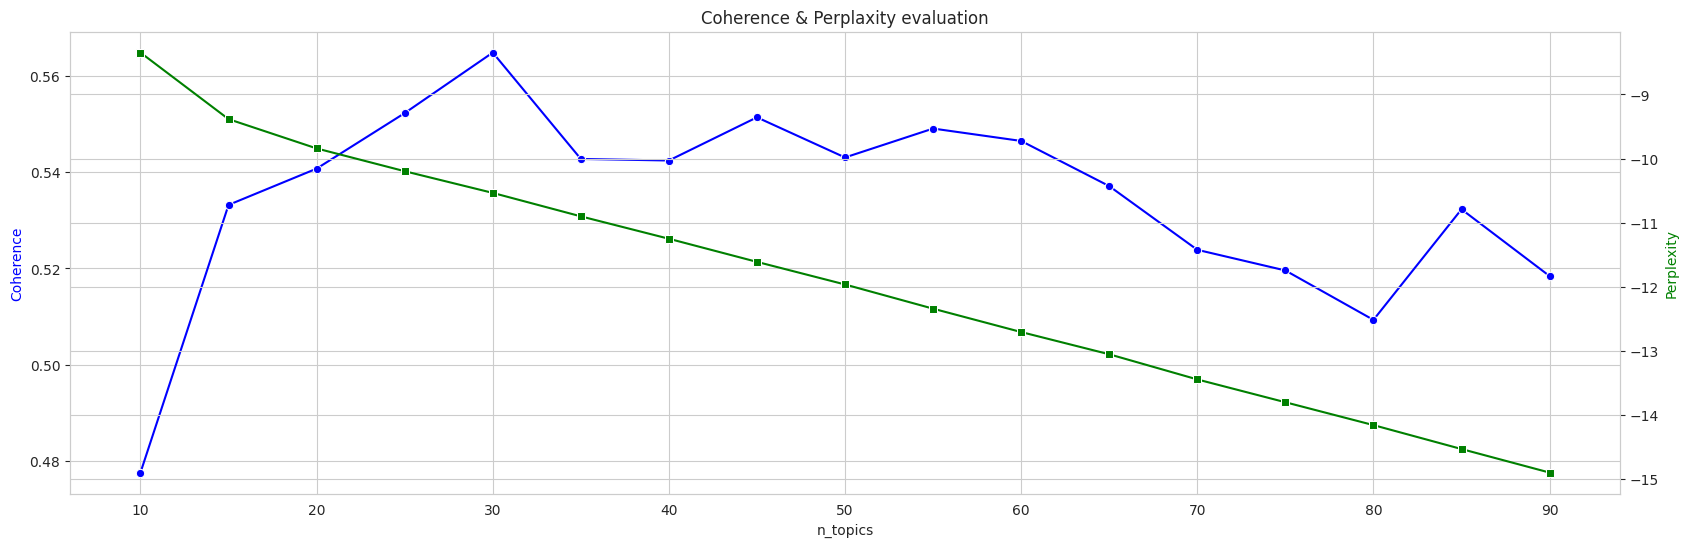

In [26]:
metrics = get_metrics(range(10, 95, 5), perplexity_scores, coherence_scores, plot=True)

In [27]:
metrics

,n_topics,perplexity,coherence
0,10,-8.345945,0.477576
1,15,-9.384462,0.533172
2,20,-9.841547,0.540706
3,25,-10.197059,0.552239
4,30,-10.535327,0.564808
5,35,-10.901292,0.542719
6,40,-11.250940,0.542393
7,45,-11.611694,0.551361
8,50,-11.964400,0.543023
9,55,-12.341937,0.549030


### 30-topics LDA model

In [30]:
%%time

n_topics = 30 # Selected number of topics

lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        max_iter=10,
        learning_method='batch'
    )
    
topic_weights = lda.fit_transform(X)

texts["topic"] = topic_weights.argmax(axis=1) # Assigns topic to each text

CPU times: user 1h 18min 16s, sys: 5h 8min 41s, total: 6h 26min 58s
Wall time: 14min 38s


### Topics Exploration
Shows top-20 words of each topic

In [34]:
n_words = 20

feature_names = vectorizer.get_feature_names_out()

t_id, t_words = [], []
for topic_idx, topic in enumerate(lda.components_):
    top_n = [feature_names[i]
             for i in topic.argsort()
             [-n_words:]][::-1]
    t_id.append(topic_idx)
    t_words.append(top_n)
    
topics_frame = pd.DataFrame(data={'topic_id':t_id, 'top_20_words':t_words})
topics_frame

,topic_id,top_20_words
0,0,"[процент, рост, ввп, экономика, инфляция, сост..."
1,1,"[российский, санкция, поставка, ес, ограничени..."
2,2,"[проект, регион, строительство, область, разви..."
3,3,"[компания, миллиард, акция, сделка, рубль, мил..."
4,4,"[цена, топливо, газ, бензин, рынок, рост, пост..."
5,5,"[компания, самолет, авиакомпания, завод, произ..."
6,6,"[закон, компания, законопроект, фото, документ..."
7,7,"[доллар, биржа, цена, рынок, стоимость, биткои..."
8,8,"[компания, сша, американский, китайский, reute..."
9,9,"[рубль, пенсионный, пенсия, бюджет, выплата, н..."


In [35]:
#topics_frame.to_csv('data/topics_frame.csv', index=False)

In [36]:
#texts.to_csv('data/labeled_texts.csv', index=False)

In [3]:
pd.read_csv('data/labeled_texts.csv')

,date,title,text,url,clean_text,lemmatized_text,processed_text,topic
0,2011-03-01,"""Газпром"" выкупил право на разработку Ковыкты","Здание ""Газпрома"". Фото (c)AFP ""Газпром"" в ход...",https://lenta.ru/news/2011/03/01/kovykta/,здание газпрома фото cafp газпром ходе торгов ...,здание газпром фото cafp газпром ход торг прио...,"['bp', 'cafp', 'reuters', 'актив', 'акционер',...",3
1,2011-03-01,Курорты Северного Кавказа уравняют в налоговых...,Эльбрус. Фото с сайта elbrus-cheget.ru Туристи...,https://lenta.ru/news/2011/03/01/ksk/,эльбрус фото сайта elbruschegetru туристически...,эльбрус фото сайт elbruschegetru туристический...,"['адыгея', 'аналогичный', 'аренда', 'аркадий',...",2
2,2011-03-01,"""Ростелеком"" начал переговоры с ""МегаФоном"" о ...","Здание ""Ростелекома"". Фото с сайта tmps.ru Тел...",https://lenta.ru/news/2011/03/01/mvno/,здание ростелекома фото сайта tmpsru телекомму...,здание ростелеком фото сайт tmpsru телекоммуни...,"['lte', 'mobile', 'network', 'абонент', 'абоне...",3
3,2011-03-01,Российский банк уничтожил всю документацию пер...,"Бланк лицензии банка ""Наш банк"". Иллюстрация с...",https://lenta.ru/news/2011/03/01/erase/,бланк лицензии банка банк иллюстрация официаль...,бланк лицензия банк банк иллюстрация официальн...,"['агентство', 'агентство страхование', 'адеква...",15
4,2011-03-01,"""Уралкалий"" успел купить часть ""Сильвинита"" до...","Производство ""Уралкалия"". Фото с сайта компани...",https://lenta.ru/news/2011/03/01/buy/,производство уралкалия фото сайта компании ура...,производство уралкалий фото сайт компания урал...,"['holdings', 'limited', 'reuters', 'акционер',...",3
...,...,...,...,...,...,...,...,...
96194,2023-12-31,Соцсеть X резко подешевела,Илон Маск Фото: Gonzalo Fuentes / Reuters Мари...,https://lenta.ru/news/2023/12/31/sotsset-x-rez...,илон маск фото gonzalo fuentes reuters марина ...,илона маск фото gonzalo fuentes reuters марина...,"['reuters', 'reuters марина', 'twitter', 'авто...",8
96195,2023-12-31,В России увеличились пенсии,Фото: Oleg Elkov / Shutterstock / Fotodom Вяче...,https://lenta.ru/news/2024/01/01/rastem/,фото oleg elkov shutterstock fotodom вячеслав ...,фото oleg elkov shutterstock fotodom вячеслав ...,"['fotodom', 'shutterstock', 'shutterstock foto...",9
96196,2023-12-31,В России обнулили пошлины на ввоз яиц из-за ру...,Фото: Александр Кряжев / РИА Новости Вячеслав ...,https://lenta.ru/news/2024/01/01/obnulyaem/,фото александр кряжев риа новости вячеслав ага...,фото александра кряжевый риа новость вячеслав ...,"['агапов', 'агропромышленный', 'агропромышленн...",27
96197,2023-12-31,В России увеличили минимальные зарплаты,Фото: Дмитрий Ермаков / «Лента.ру» Вячеслав Аг...,https://lenta.ru/news/2024/01/01/rost_zafiksir...,фото дмитрий ермаков лентару вячеслав агапов я...,фото дмитрия ермаков лентару вячеслав агапов я...,"['август', 'автор', 'автор законопроект', 'ага...",9
